In [1]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from scipy.fftpack import fft, ifft
import pandas as pd
%load_ext autoreload
%autoreload 2
import sys
import copy

from pyha import Hardware, simulate, sims_close, Complex, resize, hardware_sims_equal
from pathlib import Path
from data import load_iq
sys.path.insert(0,'/home/gaspar/git/pyhacores/under_construction/fft/')
from under_construction.fft.bit_reversal_fftshift import BitReversal
from under_construction.fft.conjmult import ConjMult
from under_construction.fft.fft_core import R2SDF
from under_construction.fft.windower import Windower
from under_construction.fft.avg_decimate import AvgDecimate
from under_construction.fft.spectrogram import Spectrogram
from under_construction.fft.packager import Packager, DataWithIndex

def imshow(im):
    from skimage.exposure import exposure
    p2, p98 = np.percentile(im, (2, 98))
    im = exposure.rescale_intensity(im, in_range=(p2, p98))

    
    plt.imshow(im, interpolation='nearest', aspect='auto', origin='lower')
    plt.tight_layout()
    plt.show()
    
    
def snr(pure, noisy):
    sig_pow = np.mean(np.abs(pure))
    error = np.array(pure) - np.array(noisy)
    err_pow = np.mean(np.abs(error))
    
    snr_db = 20*np.log10(sig_pow/err_pow)
    return snr_db


# Config

In [2]:
fft_points = 256
freq_axis_avg_decimation = 2
sims = ['MODEL', 'PYHA']

# Prepare input

In [3]:
orig_inp = load_iq('/home/gaspar/git/pyhacores/data/f2404_fs16.896_one_hop.iq')
orig_inp = signal.decimate(orig_inp, 8)
orig_inp *= 0.5

# make sure input divides with fft_points
orig_inp = np.array(orig_inp[:int(len(orig_inp) // fft_points) * fft_points])

# Golden output

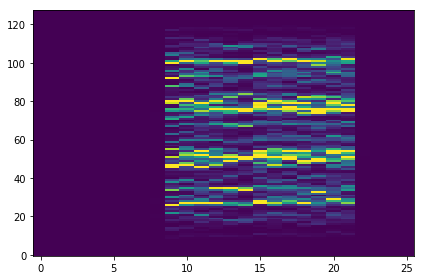

In [4]:
_, _, spectro_out = signal.spectrogram(orig_inp, 1, nperseg=fft_points, return_onesided=False, detrend=False,
                               noverlap=0, window='hann')

# fftshift
spectro_out = np.roll(spectro_out, fft_points//2, axis=0)

# avg decimation
x = np.split(spectro_out, len(spectro_out) // freq_axis_avg_decimation)
golden_output = np.average(x, axis=1)

imshow(golden_output)

# Packager

In [5]:
dut = Packager(fft_points)
sims = simulate(dut, orig_inp, output_callback=DataWithIndex.unpack, simulations=sims)
assert sims_close(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=0.0001, atol=3.0517578125e-05)
INFO:sim:Using "MODEL" as golden output
INFO:sim:MODEL OK!
INFO:sim:PYHA OK!


In [6]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 96.50822491750137


# Apply windowing

In [7]:
dut = Windower(fft_points)

In [8]:
inp = np.array(sims['PYHA'])
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex.unpack, input_callback=DataWithIndex.pack)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


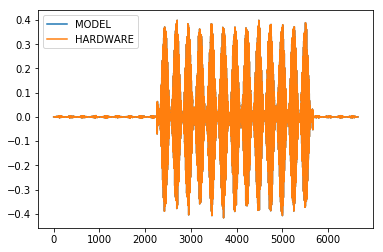

In [9]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [10]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 84.22736738279312


# FFT

In [11]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = R2SDF(fft_points)
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex.unpack, input_callback=DataWithIndex.pack)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


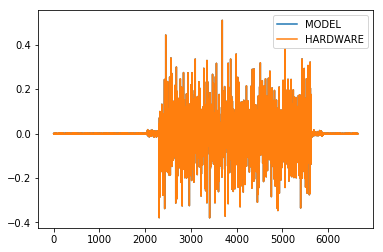

In [12]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [13]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 65.6383710267319


# Bit-reversal and fftshift

In [14]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = BitReversal(fft_points)
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex.unpack, input_callback=DataWithIndex.pack)
assert hardware_sims_equal(sims)


INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


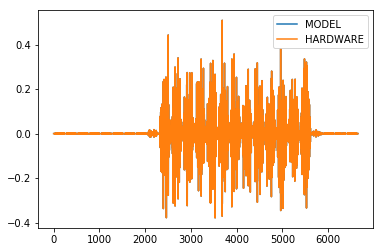

In [15]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [16]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: inf


/home/gaspar/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:39: RuntimeWarning: divide by zero encountered in double_scalars


# Magnitude

In [17]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = ConjMult()
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex.unpack, input_callback=DataWithIndex.pack)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


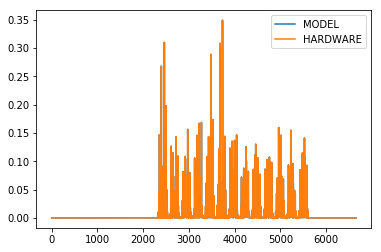

In [18]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [19]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 69.70566056466683


# Decimation AVG

In [20]:
inp = np.array(sims['PYHA']) # input is the output of last block
dut = AvgDecimate(freq_axis_avg_decimation)
sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex.unpack, input_callback=DataWithIndex.pack)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


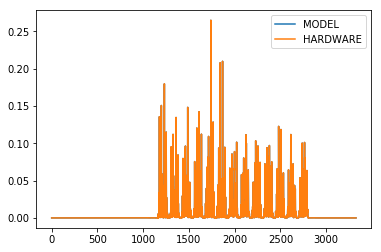

In [21]:
plt.plot(np.hstack(sims['MODEL']).real, label='MODEL')
plt.plot(np.hstack(sims['PYHA']).real, label='HARDWARE')
plt.legend()
plt.show()

In [22]:
snrs = snr(sims['MODEL'], sims['PYHA'])
print(f'Block AVG SNR: {snrs}')

Block AVG SNR: 77.38866162220909


# Merged object

In [23]:
inp = orig_inp
dut = Spectrogram(fft_points, decimate_by=freq_axis_avg_decimation)
full_sims = simulate(dut, inp, simulations=sims, output_callback=DataWithIndex.unpack)
assert hardware_sims_equal(sims)

INFO:sim:Running "MODEL" simulation...
INFO:sim:OK!
INFO:sim:Converting model to hardware types ...
INFO:sim:Converting simulation inputs to hardware types...
INFO:sim:Running "PYHA" simulation...
INFO:sim:OK!
INFO:sim:Simulations completed!
INFO:sim:sims_close(rtol=1e-16, atol=1e-16)
INFO:sim:Using "PYHA" as golden output
INFO:sim:PYHA OK!


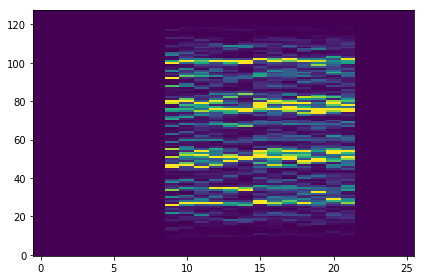

In [24]:
x = np.array(full_sims['PYHA']).T
imshow(x)

# Final evaluation

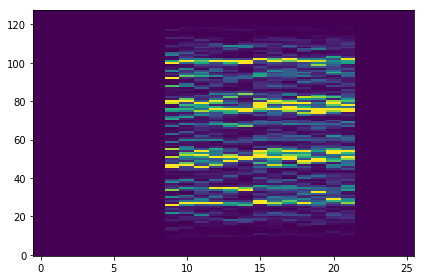

In [25]:
x = np.array(sims['PYHA']).T
imshow(x)

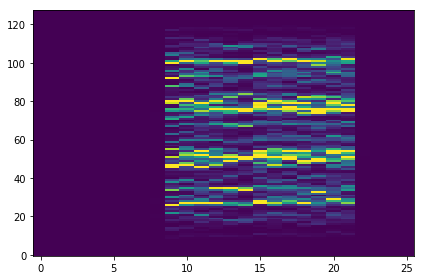

In [26]:
imshow(golden_output)

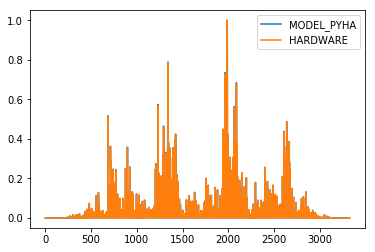

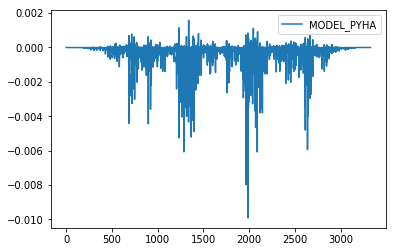

In [27]:
flat_spectro = golden_output.flatten()
flat_spectro /= golden_output.max()

flat_pyha = x.flatten()
flat_pyha /= flat_pyha.max()

plt.plot(flat_spectro, label='MODEL_PYHA')
plt.plot(flat_pyha, label='HARDWARE')
plt.legend()
plt.show()

plt.plot(flat_pyha - flat_spectro, label='MODEL_PYHA')
plt.legend()
plt.show()
